# Lemmatisierer Evaluierung

In [1]:
import glob
import json
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

In [2]:
FILES = glob.glob("results-*.json")
data = []
algos = []
corpora = []
for FILE in FILES:
    algos.append(FILE.split('.')[0].split('results-')[1])
    with open(FILE, "r") as fp:
        results = json.load(fp)
        data += results
        print(len(results))
        if algos[-1] == 'baseline':
            corpora = [f['dataset'] for f in results]
        if len(results) != len(corpora) and len(results) != 0:  # check for unlemmatized datasets
            print(set(corpora).difference(set([f['dataset'] for f in results])))

29
29
1
{'nosta-d-tuebadz-orig', 'nosta-d-unicum-norm', 'empirist-cmc-chat-social-norm', 'nosta-d-kafka-orig', 'empirist-cmc-blog', 'empirist-web', 'nosta-d-anselm-norm', 'nosta-d-unicum-orig', 'empirist-cmc-chat-prof-norm', 'ud-pud', 'empirist-cmc-twitter', 'empirist-cmc-chat-social', 'empirist-web-norm', 'empirist-cmc-wiki', 'empirist-cmc-whatsapp', 'nosta-d-falko-orig', 'empirist-cmc-twitter-norm', 'tgermacorp', 'empirist-cmc-chat-prof', 'nosta-d-falko-norm', 'nosta-d-anselm-orig', 'ud-hdt', 'nosta-d-kafka-norm', 'nosta-d-bematac-norm', 'empirist-cmc-blog-norm', 'nosta-d-bematac-orig', 'empirist-cmc-wiki-norm', 'empirist-cmc-whatsapp-norm'}
1
{'nosta-d-tuebadz-orig', 'nosta-d-unicum-norm', 'empirist-cmc-chat-social-norm', 'nosta-d-kafka-orig', 'empirist-cmc-blog', 'empirist-web', 'nosta-d-anselm-norm', 'nosta-d-unicum-orig', 'empirist-cmc-chat-prof-norm', 'ud-pud', 'empirist-cmc-twitter', 'empirist-cmc-chat-social', 'empirist-web-norm', 'empirist-cmc-wiki', 'empirist-cmc-whatsapp', 

In [3]:
algos

['baseline',
 'germalemma',
 'hanta-pretagged',
 'hanta',
 'simplemma',
 'smorlemma',
 'spacy2',
 'spacy3',
 'spacy33+',
 'stanza-pretagged',
 'stanza',
 'trankit',
 'treetagger']

In [4]:
corpora

['ud-hdt',
 'ud-gsd',
 'ud-pud',
 'nosta-d-tuebadz-orig',
 'nosta-d-anselm-orig',
 'nosta-d-anselm-norm',
 'nosta-d-kafka-orig',
 'nosta-d-kafka-norm',
 'nosta-d-bematac-orig',
 'nosta-d-bematac-norm',
 'nosta-d-unicum-orig',
 'nosta-d-unicum-norm',
 'nosta-d-falko-orig',
 'nosta-d-falko-norm',
 'empirist-cmc-twitter-norm',
 'empirist-cmc-twitter',
 'empirist-cmc-wiki-norm',
 'empirist-cmc-wiki',
 'empirist-cmc-blog-norm',
 'empirist-cmc-blog',
 'empirist-cmc-chat-prof-norm',
 'empirist-cmc-chat-prof',
 'empirist-cmc-chat-social-norm',
 'empirist-cmc-chat-social',
 'empirist-cmc-whatsapp-norm',
 'empirist-cmc-whatsapp',
 'empirist-web-norm',
 'empirist-web',
 'tgermacorp']

In [5]:
len(data)

261

### Dataset overview

In [6]:
datasets = pd.DataFrame(columns=['corpus', 'size', 'lemma tokens', 'lemma types'])
for d in data[:29]:  # baseline files
    if 'norm' in d['dataset']:  # only original file
        continue
    line = [d['dataset'], d['sample-size'], d['metrics']['overall']['number_of_lemmata'],
           d['metrics']['overall']['true-pred-types'][0]]
    datasets.loc[len(datasets)] = line
datasets = datasets.set_index('corpus')

In [7]:
datasets

,size,lemma tokens,lemma types
corpus,,,
ud-hdt,321919,151291,16640
ud-gsd,15229,7060,3853
ud-pud,21304,9831,4980
nosta-d-tuebadz-orig,5415,2464,1503
nosta-d-anselm-orig,1355,558,202
nosta-d-kafka-orig,5194,1959,842
nosta-d-bematac-orig,8122,2932,566
nosta-d-unicum-orig,5655,1811,753
nosta-d-falko-orig,1087,462,251


In [ ]:
datasets_grouped = pd.DataFrame(columns=['corpus', 'size', 'lemma tokens', 'lemma types'])


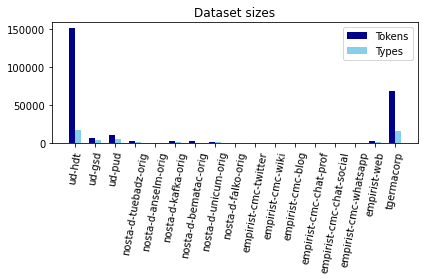

In [8]:
labels = datasets.index
tokens = datasets['lemma tokens']
types = datasets['lemma types']

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, tokens, width, label='Tokens', color="darkblue")
rects2 = ax.bar(x + width/2, types, width, label='Types', color="skyblue")

# Add some text for labels, title and custom x-axis tick labels, etc.
#ax.set_ylabel('Scores')
ax.set_title('Dataset sizes')
ax.set_xticks(x)#, labels
ax.set_xticklabels(labels)
ax.legend()
plt.xticks(rotation=80)

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()

In [ ]:
# TODO group together subcorpora


In [ ]:
# TODO compare standard and non standard

In [11]:
def generate_table(df, feature, plot=True):
    table = pd.DataFrame(columns=['algorithm']+corpora)
    line = []
    algo_index = 0
    for d in data:
        if type(feature) == str:
            line.append(d[feature])
        elif type(feature) == list:
            if feature[0] and feature[1]:
                if feature[2]:
                    if len(feature) > 3:
                        line.append(d[feature[0]][feature[1]][feature[2]][feature[3]])
                    else:
                        line.append(d[feature[0]][feature[1]][feature[2]])
                else:
                    line.append(d[feature[0]][feature[1]])
        if d['dataset'] == 'tgermacorp':  # last corpus reached, next algorithm
            # exception for stanza, 2 corpora not covered: 'empirist-web-norm', 'empirist-web'
            if d['lemmatizer'] == 'stanza':
                line.insert(-1, 0)
                line.insert(-1, 0)
            table.loc[len(table)] = [d['lemmatizer']] + line
            line = []
            algo_index += 1  # next algorithm
    table = table.set_index('algorithm')
    table = table.astype(float)
    if plot:
        sns.heatmap(table, cmap="YlGnBu")
    return table

In [32]:
# resume all corpora
df2 = pd.DataFrame(columns=['algorithm', 'time', 'memory', 'accuracy', 'adj_accuracy', 'adj_precision',
                            'adj_recall', 'adj_f1', 'levenshtein', 'type-ratio'])
current_algo = 'baseline'
time, memory, acc, adj_acc, adj_pre, adj_re, adj_f1, leven, types = [], [], [], [], [], [], [], [], []

for d in data: 
    if d["lemmatizer"] != current_algo or (data.index(d) == len(data)-1):  # next algorithm
        df2.loc[len(df2)] = [current_algo, np.mean(time), np.mean(memory), np.mean(acc),
                             np.mean(adj_acc), np.mean(adj_pre), np.mean(adj_re), np.mean(adj_f1),
                             np.mean(leven), np.mean(types)]
        current_algo = d["lemmatizer"]
        time, memory, acc, adj_acc, adj_pre, adj_re, adj_f1, leven, types = [], [], [], [], [], [], [], [], []
    time.append(d["elapsed"])
    memory.append(d["memory_peak"])
    acc.append(d['metrics']['overall']['accuracy'])
    adj_acc.append(d['metrics']['overall']['adj_accuracy'])
    adj_pre.append(d['metrics']['overall']['adj_precision'])
    adj_re.append(d['metrics']['overall']['adj_recall'])
    adj_f1.append(d['metrics']['overall']['adj_f1'])
    leven.append(d['metrics']['overall']['levenshtein'])
    types.append(d['metrics']['overall']['true-pred-types'][2])
    
df2 = df2.set_index('algorithm')

In [33]:
df2

,time,memory,accuracy,adj_accuracy,adj_precision,adj_recall,adj_f1,levenshtein,type-ratio
algorithm,,,,,,,,,
baseline,0.000001,3.944828e+01,0.588540,0.593787,0.424723,0.399017,0.404305,0.890466,0.842047
germalemma,0.110076,2.030797e+06,0.800919,0.791153,0.721243,0.717746,0.717048,0.817975,1.060900
simplemma,0.058762,6.292291e+06,0.847274,0.818663,0.710203,0.704714,0.704241,0.387145,0.967060
spacy2,2.643309,2.061978e+07,0.796506,0.771193,0.643429,0.632223,0.633534,0.460648,0.937153
spacy3,0.188346,9.897145e+06,0.796506,0.771193,0.643429,0.632223,0.633534,0.460648,0.937153
spacy33+,31.806199,1.835712e+07,0.864580,0.847344,0.752166,0.744565,0.745192,0.351964,0.952631
stanza,12.555349,4.377655e+07,0.832952,0.801034,0.690716,0.684165,0.684355,0.433105,0.957650
trankit,5.677843,2.468106e+07,0.816771,0.783404,0.661897,0.652763,0.653888,0.464716,0.947395
treetagger,1.469593,9.856454e+05,0.698469,0.675984,0.592270,0.576503,0.580101,1.596062,1.018475


(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]),
 [Text(-1.0, 0, 'treetagger'),
  Text(0.0, 0, 'baseline'),
  Text(1.0, 0, 'germalemma'),
  Text(2.0, 0, 'simplemma'),
  Text(3.0, 0, 'spacy2'),
  Text(4.0, 0, 'spacy3'),
  Text(5.0, 0, 'spacy33+'),
  Text(6.0, 0, 'stanza'),
  Text(7.0, 0, 'trankit'),
  Text(8.0, 0, 'treetagger'),
  Text(9.0, 0, '')])

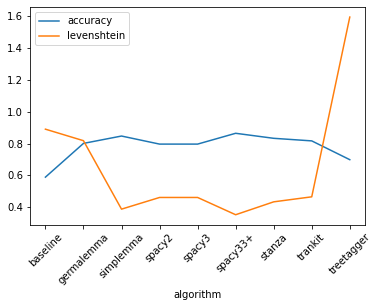

In [42]:
df2[['accuracy','levenshtein']].plot.line()
plt.xticks(rotation=45)

In [34]:
df2.corr()

,time,memory,accuracy,adj_accuracy,adj_precision,adj_recall,adj_f1,levenshtein,type-ratio
time,1.000000,0.468994,0.462082,0.495034,0.466847,0.454975,0.458764,-0.369830,-0.036621
memory,0.468994,1.000000,0.537720,0.496974,0.391631,0.392532,0.392147,-0.560719,-0.096486
accuracy,0.462082,0.537720,1.000000,0.993968,0.959200,0.959213,0.958753,-0.671725,0.444564
adj_accuracy,0.495034,0.496974,0.993968,1.000000,0.967259,0.967013,0.966481,-0.686903,0.444723
adj_precision,0.466847,0.391631,0.959200,0.967259,1.000000,0.999852,0.999931,-0.486778,0.647215
adj_recall,0.454975,0.392532,0.959213,0.967013,0.999852,1.000000,0.999977,-0.487808,0.651162
adj_f1,0.458764,0.392147,0.958753,0.966481,0.999931,0.999977,1.000000,-0.485067,0.651689
levenshtein,-0.369830,-0.560719,-0.671725,-0.686903,-0.486778,-0.487808,-0.485067,1.000000,0.289201
type-ratio,-0.036621,-0.096486,0.444564,0.444723,0.647215,0.651162,0.651689,0.289201,1.000000


observations:
- confusion matrix measures highly correlated (no surprise)
- time and memory not too strongly correlated (0.468994)
- levenshtein & confusion matrix measures negatively correlated

,ud-hdt,ud-gsd,ud-pud,nosta-d-tuebadz-orig,nosta-d-anselm-orig,nosta-d-anselm-norm,nosta-d-kafka-orig,nosta-d-kafka-norm,nosta-d-bematac-orig,nosta-d-bematac-norm,...,empirist-cmc-blog,empirist-cmc-chat-prof-norm,empirist-cmc-chat-prof,empirist-cmc-chat-social-norm,empirist-cmc-chat-social,empirist-cmc-whatsapp-norm,empirist-cmc-whatsapp,empirist-web-norm,empirist-web,tgermacorp
algorithm,,,,,,,,,,,,,,,,,,,,,
baseline,0.536146,0.626204,0.589665,0.616071,0.055556,0.495528,0.606942,0.612328,0.801501,0.705787,...,0.593750,0.747549,0.625000,0.761557,0.381995,0.731579,0.615789,0.606595,0.575476,0.536667
germalemma,0.664825,0.834278,0.792086,0.792614,0.191756,0.765653,0.903012,0.912888,0.749659,0.893056,...,0.867188,0.914216,0.882353,0.642336,0.571776,0.931579,0.926316,0.845332,0.838365,0.830119
simplemma,0.761651,0.909915,0.903672,0.883523,0.202509,0.912343,0.922409,0.937341,0.766371,0.875000,...,0.906250,0.911765,0.843137,0.931873,0.681265,0.936842,0.852632,0.900139,0.882954,0.828413
spacy2,0.751975,0.875496,0.871936,0.843750,0.150538,0.910555,0.893313,0.896587,0.750341,0.793287,...,0.804688,0.904412,0.774510,0.934307,0.535280,0.915789,0.773684,0.858337,0.824431,0.783883
spacy3,0.751975,0.875496,0.871936,0.843750,0.150538,0.910555,0.893313,0.896587,0.750341,0.793287,...,0.804688,0.904412,0.774510,0.934307,0.535280,0.915789,0.773684,0.858337,0.824431,0.783883
spacy33+,0.779009,0.959490,0.941003,0.917614,0.200717,0.919499,0.935681,0.938360,0.752046,0.849074,...,0.867188,0.980392,0.904412,0.917275,0.715328,0.947368,0.894737,0.961914,0.943335,0.854421
stanza,0.784686,0.941076,0.941410,0.911526,0.161290,0.940966,0.913221,0.922567,0.732265,0.860648,...,0.843750,0.960784,0.867647,0.931873,0.547445,0.931579,0.836842,0.000000,0.000000,0.828059
trankit,0.768142,0.923088,0.927373,0.883117,0.166667,0.889088,0.883104,0.893021,0.735334,0.842130,...,0.828125,0.946078,0.835784,0.919708,0.532847,0.947368,0.821053,0.882954,0.862053,0.795313
treetagger,0.732456,0.835836,0.914454,0.870942,0.175627,0.949911,0.753446,0.764137,0.744543,0.859954,...,0.460938,0.928922,0.850490,0.905109,0.661800,0.831579,0.773684,0.658151,0.647004,0.860615


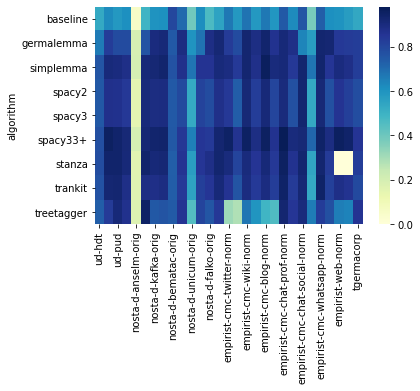

In [12]:
# accuracy
generate_table(data, ['metrics','overall','accuracy'])

,ud-hdt,ud-gsd,ud-pud,nosta-d-tuebadz-orig,nosta-d-anselm-orig,nosta-d-anselm-norm,nosta-d-kafka-orig,nosta-d-kafka-norm,nosta-d-bematac-orig,nosta-d-bematac-norm,...,empirist-cmc-blog,empirist-cmc-chat-prof-norm,empirist-cmc-chat-prof,empirist-cmc-chat-social-norm,empirist-cmc-chat-social,empirist-cmc-whatsapp-norm,empirist-cmc-whatsapp,empirist-web-norm,empirist-web,tgermacorp
algorithm,,,,,,,,,,,,,,,,,,,,,
baseline,0.000010,0.000002,0.000001,0.000001,7.152557e-07,9.536743e-07,0.000004,0.000001,0.000001,0.000001,...,7.152557e-07,4.768372e-07,7.152557e-07,7.152557e-07,7.152557e-07,9.536743e-07,7.152557e-07,7.152557e-07,9.536743e-07,0.000002
germalemma,2.142925,0.045309,0.105102,0.033496,9.042740e-03,2.724409e-03,0.013199,0.009048,0.023710,0.021410,...,1.129866e-03,5.566597e-03,3.403902e-03,2.443075e-03,2.975702e-03,1.781940e-03,1.401663e-03,2.632785e-02,1.094580e-02,0.659096
simplemma,1.359348,0.033337,0.039804,0.011167,2.717257e-03,1.054525e-03,0.007597,0.002721,0.009385,0.009757,...,4.339218e-04,1.380205e-03,8.480549e-04,1.060724e-03,8.511543e-04,7.028580e-04,5.171299e-04,9.083509e-03,2.887249e-03,0.180653
spacy2,37.655830,2.091829,2.600766,0.727722,1.263287e-01,2.541361e-01,0.603422,0.607417,1.540947,2.532684,...,2.614498e-02,2.252433e-01,2.236454e-01,4.468524e-01,4.505794e-01,1.046658e-01,1.052594e-01,4.710474e-01,4.671352e-01,22.138546
spacy3,3.065247,0.154291,0.206674,0.053512,1.265883e-02,1.014876e-02,0.034647,0.029730,0.055788,0.079646,...,2.794266e-03,1.212478e-02,9.011745e-03,1.275539e-02,1.151252e-02,5.882502e-03,4.963398e-03,4.319429e-02,2.864623e-02,1.467191
spacy33+,477.187818,24.355315,28.735961,8.497742,1.621092e+00,2.899279e+00,6.851646,6.867602,18.365620,29.813474,...,3.166358e-01,2.616139e+00,2.639331e+00,5.392761e+00,5.436773e+00,1.331755e+00,1.331373e+00,5.626328e+00,5.575744e+00,247.855176
stanza,198.180946,7.693868,10.259934,4.090499,1.441758e+00,6.689305e-01,2.871983,2.669981,9.728632,7.426282,...,3.246326e-01,6.828961e-01,6.797912e-01,1.022450e+00,1.071663e+00,6.285167e-01,6.217363e-01,0.000000e+00,0.000000e+00,72.668480
trankit,92.075847,5.126267,5.251806,1.631051,5.357308e-01,4.343665e-01,1.486821,1.241671,1.673151,2.563111,...,3.043888e-01,5.203922e-01,5.858243e-01,9.413936e-01,9.609404e-01,8.242714e-01,7.694921e-01,1.474404e+00,1.565699e+00,34.579236
treetagger,29.664026,1.436998,1.829095,0.498042,8.549881e-02,1.623814e-01,0.430194,0.430972,1.022477,1.674016,...,2.049303e-02,1.460686e-01,1.459277e-01,2.915311e-01,2.881613e-01,6.984043e-02,6.990361e-02,3.549004e-01,3.515089e-01,15.010635


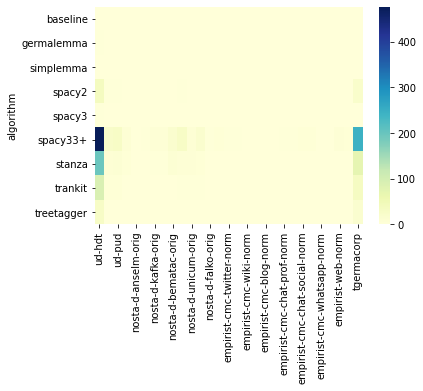

In [13]:
generate_table(data, 'elapsed')

,ud-hdt,ud-gsd,ud-pud,nosta-d-tuebadz-orig,nosta-d-anselm-orig,nosta-d-anselm-norm,nosta-d-kafka-orig,nosta-d-kafka-norm,nosta-d-bematac-orig,nosta-d-bematac-norm,...,empirist-cmc-blog,empirist-cmc-chat-prof-norm,empirist-cmc-chat-prof,empirist-cmc-chat-social-norm,empirist-cmc-chat-social,empirist-cmc-whatsapp-norm,empirist-cmc-whatsapp,empirist-web-norm,empirist-web,tgermacorp
algorithm,,,,,,,,,,,,,,,,,,,,,
baseline,496.0,0.0,0.0,0.0,0.0,48.0,72.0,48.0,0.0,48.0,...,48.0,0.0,48.0,0.0,48.0,0.0,48.0,0.0,48.0,0.0
germalemma,29337051.0,445654.0,1072819.0,365690.0,18424434.0,34323.0,164403.0,129141.0,242520.0,312534.0,...,12293.0,57088.0,38184.0,24029.0,28308.0,21412.0,17376.0,290233.0,130179.0,7046389.0
simplemma,172822411.0,600686.0,3409533.0,186298.0,73801.0,22706.0,90122.0,62834.0,161200.0,215558.0,...,8886.0,30923.0,20271.0,32077.0,27384.0,16210.0,12554.0,149956.0,58431.0,3919518.0
spacy2,352423057.0,13160833.0,17285583.0,4514970.0,1336909.0,1340931.0,4119725.0,4121543.0,10448716.0,12864585.0,...,742342.0,1193656.0,1193456.0,1904625.0,1910453.0,627553.0,630258.0,4272894.0,4250923.0,139359333.0
spacy3,158755532.0,9213360.0,8307398.0,2258203.0,434195.0,773655.0,1891728.0,1869260.0,5350730.0,8438941.0,...,97896.0,712753.0,700716.0,1502206.0,1498460.0,328364.0,321728.0,1746617.0,1646353.0,70722350.0
spacy33+,250276636.0,14259940.0,14609483.0,4130722.0,2593586.0,1728737.0,3696662.0,3675722.0,30121147.0,20754081.0,...,1684801.0,1551599.0,1540080.0,2702881.0,2708236.0,996173.0,992503.0,7603307.0,7504281.0,134541136.0
stanza,497860591.0,24891181.0,32442834.0,15108791.0,4832711.0,6028854.0,18543354.0,18563794.0,129133324.0,75883598.0,...,870652.0,3743139.0,3743222.0,4406510.0,4402801.0,1702056.0,1702866.0,0.0,0.0,278396198.0
trankit,375388621.0,19852042.0,26524169.0,8414314.0,2119619.0,2256954.0,7968403.0,8186370.0,11384648.0,15491662.0,...,590794.0,1727339.0,1723982.0,1941991.0,1943882.0,941707.0,942355.0,7768762.0,7769900.0,181069333.0
treetagger,20562665.0,952248.0,1342882.0,322648.0,90312.0,90613.0,300974.0,307653.0,595972.0,718110.0,...,56903.0,74666.0,72399.0,83301.0,84038.0,42872.0,43491.0,329808.0,330419.0,9641887.0


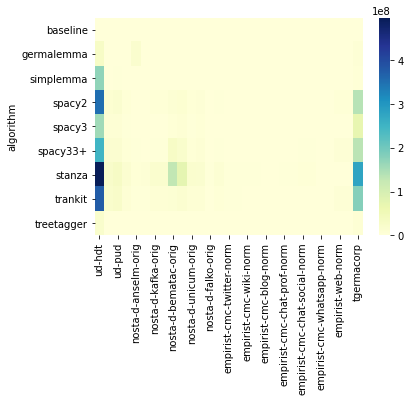

In [14]:
generate_table(data, 'memory_peak')

,ud-hdt,ud-gsd,ud-pud,nosta-d-tuebadz-orig,nosta-d-anselm-orig,nosta-d-anselm-norm,nosta-d-kafka-orig,nosta-d-kafka-norm,nosta-d-bematac-orig,nosta-d-bematac-norm,...,empirist-cmc-blog,empirist-cmc-chat-prof-norm,empirist-cmc-chat-prof,empirist-cmc-chat-social-norm,empirist-cmc-chat-social,empirist-cmc-whatsapp-norm,empirist-cmc-whatsapp,empirist-web-norm,empirist-web,tgermacorp
algorithm,,,,,,,,,,,,,,,,,,,,,
baseline,0.284369,0.434128,0.405249,0.414511,0.031410,0.320404,0.365150,0.372453,0.675360,0.576489,...,0.416143,0.558646,0.415185,0.511094,0.189193,0.542914,0.404189,0.428379,0.397815,0.299872
germalemma,0.250190,0.765612,0.672677,0.759589,0.102609,0.794806,0.834379,0.847929,0.571434,0.672545,...,0.764463,0.888298,0.814576,0.732304,0.602541,0.884860,0.870581,0.780892,0.764239,0.579515
simplemma,0.389592,0.794445,0.774211,0.757827,0.093267,0.799017,0.796780,0.822722,0.587644,0.665179,...,0.827731,0.808936,0.684871,0.820755,0.494934,0.856790,0.696309,0.806963,0.783147,0.570129
spacy2,0.390532,0.741034,0.711071,0.698875,0.055909,0.728081,0.759613,0.766695,0.571567,0.601274,...,0.659091,0.776099,0.576116,0.833333,0.342413,0.836983,0.586934,0.738949,0.686506,0.493632
spacy3,0.390532,0.741034,0.711071,0.698875,0.055909,0.728081,0.759613,0.766695,0.571567,0.601274,...,0.659091,0.776099,0.576116,0.833333,0.342413,0.836983,0.586934,0.738949,0.686506,0.493632
spacy33+,0.385505,0.904859,0.864971,0.848359,0.091969,0.773137,0.833425,0.844536,0.554253,0.623429,...,0.752000,0.955536,0.788172,0.835383,0.528477,0.909091,0.782051,0.917861,0.878788,0.604704
stanza,0.389449,0.845163,0.838152,0.811530,0.066723,0.788633,0.798355,0.813462,0.547252,0.615588,...,0.714844,0.900174,0.718000,0.820707,0.354665,0.849383,0.676049,0.000000,0.000000,0.560887
trankit,0.368369,0.803415,0.801036,0.750848,0.066178,0.735420,0.708946,0.725966,0.557819,0.594764,...,0.692308,0.867630,0.662995,0.793556,0.336553,0.870647,0.643548,0.775176,0.742441,0.499504
treetagger,0.378541,0.777044,0.840276,0.799618,0.081781,0.843295,0.659079,0.670687,0.569054,0.671813,...,0.335697,0.871322,0.731703,0.799057,0.480209,0.730420,0.617641,0.570330,0.555345,0.625976


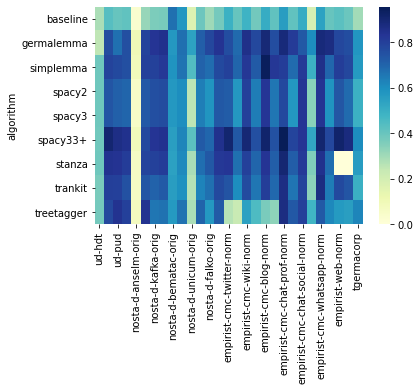

In [19]:
# recall
generate_table(data, ['metrics','overall','adj_recall'])

,ud-hdt,ud-gsd,ud-pud,nosta-d-tuebadz-orig,nosta-d-anselm-orig,nosta-d-anselm-norm,nosta-d-kafka-orig,nosta-d-kafka-norm,nosta-d-bematac-orig,nosta-d-bematac-norm,...,empirist-cmc-blog,empirist-cmc-chat-prof-norm,empirist-cmc-chat-prof,empirist-cmc-chat-social-norm,empirist-cmc-chat-social,empirist-cmc-whatsapp-norm,empirist-cmc-whatsapp,empirist-web-norm,empirist-web,tgermacorp
algorithm,,,,,,,,,,,,,,,,,,,,,
baseline,0.325242,0.467925,0.442225,0.439375,0.034188,0.347674,0.403848,0.411846,0.676337,0.573054,...,0.421384,0.585165,0.441748,0.518576,0.217949,0.568862,0.433155,0.460526,0.431353,0.342916
germalemma,0.277245,0.771072,0.677854,0.763656,0.113158,0.800000,0.833722,0.848644,0.535238,0.651614,...,0.772727,0.888298,0.818644,0.733591,0.608156,0.893130,0.878788,0.786840,0.770014,0.597477
simplemma,0.412917,0.800250,0.782794,0.763250,0.103044,0.806608,0.794577,0.819658,0.546202,0.645383,...,0.844538,0.815789,0.700906,0.820755,0.514970,0.859259,0.704698,0.811529,0.789482,0.579053
spacy2,0.414137,0.750917,0.722027,0.708903,0.062640,0.737796,0.768836,0.778540,0.535208,0.591982,...,0.670455,0.782958,0.597493,0.832700,0.367021,0.846715,0.611111,0.748379,0.699066,0.510997
spacy3,0.414137,0.750917,0.722027,0.708903,0.062640,0.737796,0.768836,0.778540,0.535208,0.591982,...,0.670455,0.782958,0.597493,0.832700,0.367021,0.846715,0.611111,0.748379,0.699066,0.510997
spacy33+,0.404216,0.905662,0.866597,0.851569,0.102041,0.784271,0.830004,0.844623,0.533224,0.616175,...,0.768000,0.954762,0.797849,0.838141,0.552870,0.916667,0.797203,0.921071,0.884412,0.620131
stanza,0.410257,0.848384,0.842205,0.814460,0.079186,0.791667,0.801330,0.817435,0.515365,0.603112,...,0.726562,0.899884,0.732821,0.818182,0.377358,0.849383,0.685430,0.000000,0.000000,0.577207
trankit,0.391189,0.809510,0.806652,0.755881,0.074246,0.746919,0.713310,0.730504,0.534327,0.584433,...,0.707692,0.871315,0.680966,0.795539,0.360743,0.873134,0.658065,0.780733,0.749307,0.520864
treetagger,0.402396,0.793463,0.846660,0.809925,0.089655,0.858182,0.690726,0.701033,0.534116,0.650398,...,0.349882,0.877471,0.745952,0.799371,0.507418,0.758159,0.648810,0.590627,0.576624,0.635040


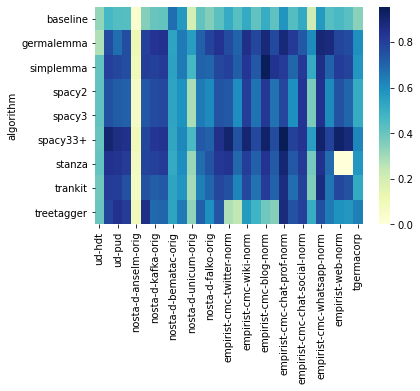

In [20]:
# precision
generate_table(data, ['metrics','overall','adj_precision'])

,ud-hdt,ud-gsd,ud-pud,nosta-d-tuebadz-orig,nosta-d-anselm-orig,nosta-d-anselm-norm,nosta-d-kafka-orig,nosta-d-kafka-norm,nosta-d-bematac-orig,nosta-d-bematac-norm,...,empirist-cmc-blog,empirist-cmc-chat-prof-norm,empirist-cmc-chat-prof,empirist-cmc-chat-social-norm,empirist-cmc-chat-social,empirist-cmc-whatsapp-norm,empirist-cmc-whatsapp,empirist-web-norm,empirist-web,tgermacorp
algorithm,,,,,,,,,,,,,,,,,,,,,
baseline,0.652851,0.386689,0.424980,0.394427,1.189942,0.541459,0.432488,0.421565,0.238445,0.277915,...,0.468723,0.266870,0.382270,0.255120,0.585287,0.295792,0.390584,0.392006,0.421869,0.490010
germalemma,0.616231,0.286938,0.325927,0.324637,0.981845,0.372595,0.114477,0.102477,0.288272,0.113819,...,0.182800,0.148312,0.188442,0.606028,0.673620,0.107415,0.115331,0.217988,0.227166,0.210199
simplemma,0.417395,0.097093,0.097799,0.121313,1.048376,0.109832,0.083454,0.063280,0.282355,0.122408,...,0.107173,0.084403,0.164185,0.064751,0.319117,0.074674,0.153360,0.098019,0.115515,0.184605
spacy2,0.420470,0.120734,0.119896,0.148822,1.073711,0.083504,0.109730,0.105136,0.295811,0.191175,...,0.252097,0.092323,0.222208,0.063795,0.412011,0.102154,0.221589,0.129116,0.161427,0.223129
spacy3,0.420470,0.120734,0.119896,0.148822,1.073711,0.083504,0.109730,0.105136,0.295811,0.191175,...,0.252097,0.092323,0.222208,0.063795,0.412011,0.102154,0.221589,0.129116,0.161427,0.223129
spacy33+,0.394478,0.044065,0.058771,0.079305,1.021290,0.086079,0.063722,0.061640,0.286104,0.148972,...,0.193857,0.020517,0.098600,0.077611,0.280818,0.061124,0.113653,0.036289,0.054483,0.152525
stanza,0.394289,0.063525,0.059862,0.090308,1.043196,0.064345,0.087747,0.075729,0.319276,0.148454,...,0.194977,0.043022,0.133922,0.069565,0.422034,0.079282,0.164089,0.000000,0.000000,0.186198
trankit,0.411514,0.084633,0.076543,0.121678,1.021753,0.115936,0.121865,0.109643,0.306281,0.158116,...,0.240443,0.061840,0.173068,0.077741,0.435812,0.071986,0.201299,0.117046,0.139406,0.224402
treetagger,0.497674,0.309776,0.124808,0.200927,1.068016,0.081020,0.427108,0.410280,0.322751,0.152596,...,0.984775,0.109690,0.228098,0.118962,0.353355,0.302992,0.347390,0.633617,0.646297,0.165648


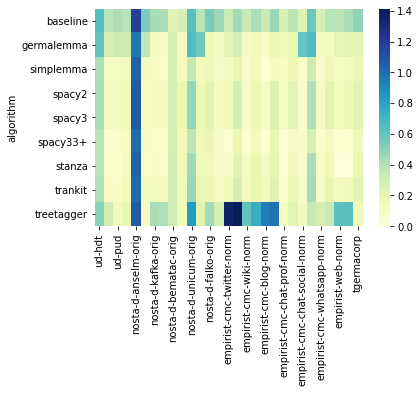

In [15]:
generate_table(data, ['metrics','overall','log-levenshtein'])

,ud-hdt,ud-gsd,ud-pud,nosta-d-tuebadz-orig,nosta-d-anselm-orig,nosta-d-anselm-norm,nosta-d-kafka-orig,nosta-d-kafka-norm,nosta-d-bematac-orig,nosta-d-bematac-norm,...,empirist-cmc-blog,empirist-cmc-chat-prof-norm,empirist-cmc-chat-prof,empirist-cmc-chat-social-norm,empirist-cmc-chat-social,empirist-cmc-whatsapp-norm,empirist-cmc-whatsapp,empirist-web-norm,empirist-web,tgermacorp
algorithm,,,,,,,,,,,,,,,,,,,,,
baseline,0.706515,0.431465,0.467456,0.445910,1.500608,0.635414,0.484863,0.470011,0.286838,0.372964,...,0.545743,0.293112,0.454111,0.306427,0.778042,0.338190,0.482423,0.433826,0.476508,0.549039
germalemma,0.636900,0.291662,0.336340,0.338557,1.173697,0.380762,0.121021,0.106175,0.360366,0.138630,...,0.199449,0.149853,0.193128,0.616533,0.694470,0.111278,0.120708,0.230234,0.238839,0.221844
simplemma,0.448270,0.115795,0.114000,0.144260,1.327265,0.131341,0.100375,0.075055,0.342449,0.157470,...,0.126930,0.096812,0.193892,0.078610,0.418001,0.084402,0.190998,0.119056,0.140268,0.210681
spacy2,0.448845,0.139006,0.133494,0.172312,1.365469,0.096957,0.130678,0.124631,0.357899,0.253631,...,0.305909,0.096873,0.268026,0.073726,0.568145,0.111908,0.281190,0.144819,0.188635,0.253526
spacy3,0.448845,0.139006,0.133494,0.172312,1.365469,0.096957,0.130678,0.124631,0.357899,0.253631,...,0.305909,0.096873,0.268026,0.073726,0.568145,0.111908,0.281190,0.144819,0.188635,0.253526
spacy33+,0.417353,0.053687,0.066154,0.095195,1.293914,0.106006,0.077540,0.073842,0.348465,0.190910,...,0.237342,0.024204,0.118421,0.103416,0.365923,0.075807,0.138876,0.043786,0.065831,0.177853
stanza,0.416149,0.071576,0.065474,0.102554,1.334804,0.072460,0.104041,0.089259,0.388181,0.182762,...,0.230777,0.045426,0.162009,0.084033,0.576495,0.089887,0.210287,0.000000,0.000000,0.208317
trankit,0.436296,0.096294,0.084436,0.140727,1.316717,0.133766,0.143781,0.128562,0.371694,0.196975,...,0.288043,0.066621,0.207705,0.095879,0.587829,0.076212,0.249672,0.131970,0.159021,0.253101
treetagger,0.536956,0.348583,0.139540,0.229135,1.348270,0.092214,0.480896,0.461224,0.385601,0.191717,...,1.133199,0.126304,0.261309,0.141116,0.461346,0.339389,0.404764,0.718869,0.732980,0.183582


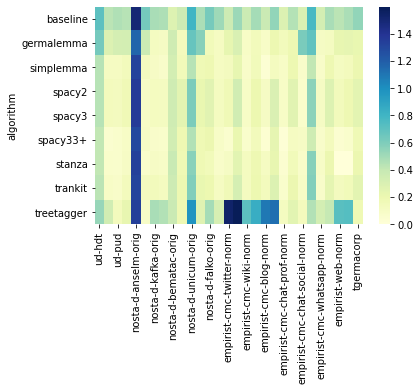

In [16]:
generate_table(data, ['metrics','overall','log-levenshtein2'])

,ud-hdt,ud-gsd,ud-pud,nosta-d-tuebadz-orig,nosta-d-anselm-orig,nosta-d-anselm-norm,nosta-d-kafka-orig,nosta-d-kafka-norm,nosta-d-bematac-orig,nosta-d-bematac-norm,...,empirist-cmc-blog,empirist-cmc-chat-prof-norm,empirist-cmc-chat-prof,empirist-cmc-chat-social-norm,empirist-cmc-chat-social,empirist-cmc-whatsapp-norm,empirist-cmc-whatsapp,empirist-web-norm,empirist-web,tgermacorp
algorithm,,,,,,,,,,,,,,,,,,,,,
baseline,1.909360,0.737819,0.803174,0.739042,2.569892,1.039356,0.854518,0.824758,0.548431,0.496528,...,1.054688,0.507353,0.742647,0.491484,1.087591,0.594737,0.752632,0.719926,0.775662,0.966180
germalemma,2.110344,0.883569,0.944665,0.943994,2.172043,1.003578,0.248596,0.224147,0.621419,0.222685,...,0.492188,0.465686,0.568627,1.727494,1.849148,0.342105,0.357895,0.619136,0.638179,0.523192
simplemma,1.431110,0.198159,0.183603,0.226867,2.306452,0.236136,0.162838,0.117677,0.638472,0.221991,...,0.250000,0.149510,0.328431,0.121655,0.625304,0.157895,0.300000,0.180678,0.212726,0.373862
spacy2,1.459856,0.235127,0.219510,0.264610,2.327957,0.146691,0.211332,0.200204,0.659618,0.338657,...,0.656250,0.164216,0.431373,0.119221,0.742092,0.215789,0.415789,0.223874,0.283326,0.439384
spacy3,1.459856,0.235127,0.219510,0.264610,2.327957,0.146691,0.211332,0.200204,0.659618,0.338657,...,0.656250,0.164216,0.431373,0.119221,0.742092,0.215789,0.415789,0.223874,0.283326,0.439384
spacy33+,1.373486,0.095751,0.109043,0.140016,2.252688,0.166369,0.118938,0.116149,0.632333,0.271296,...,0.554688,0.039216,0.210784,0.136253,0.540146,0.126316,0.226316,0.064561,0.097538,0.308560
stanza,1.403230,0.137535,0.126742,0.176542,2.249104,0.134168,0.174579,0.149261,0.719645,0.294444,...,0.492188,0.090686,0.281863,0.133820,0.795620,0.194737,0.342105,0.000000,0.000000,0.399444
trankit,1.439649,0.182011,0.161632,0.239448,2.182796,0.225403,0.242981,0.217524,0.677012,0.295602,...,0.656250,0.129902,0.362745,0.143552,0.807786,0.189474,0.447368,0.235950,0.281003,0.476602
treetagger,1.748015,1.077195,0.361611,0.631088,2.369176,0.232558,1.346095,1.297504,0.775580,0.321296,...,3.210938,0.313725,0.678922,0.304136,0.746959,0.957895,1.026316,2.163028,2.191361,0.386292


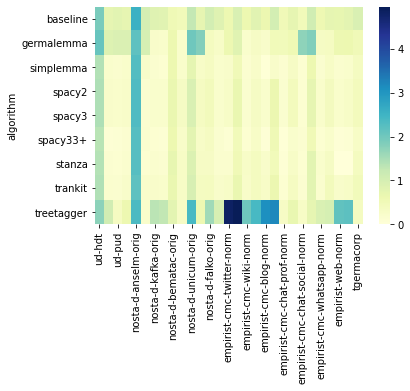

In [17]:
generate_table(data, ['metrics','overall','levenshtein'])

,ud-hdt,ud-gsd,ud-pud,nosta-d-tuebadz-orig,nosta-d-anselm-orig,nosta-d-anselm-norm,nosta-d-kafka-orig,nosta-d-kafka-norm,nosta-d-bematac-orig,nosta-d-bematac-norm,...,empirist-cmc-blog,empirist-cmc-chat-prof-norm,empirist-cmc-chat-prof,empirist-cmc-chat-social-norm,empirist-cmc-chat-social,empirist-cmc-whatsapp-norm,empirist-cmc-whatsapp,empirist-web-norm,empirist-web,tgermacorp
algorithm,,,,,,,,,,,,,,,,,,,,,
baseline,0.304772,0.115507,0.122740,0.120366,0.520374,0.205199,0.143420,0.137074,0.110240,0.102130,...,0.164027,0.079619,0.118528,0.087192,0.205704,0.101142,0.130712,0.107995,0.119197,0.153525
germalemma,0.337820,0.143275,0.154404,0.160256,0.439290,0.200204,0.060005,0.053348,0.119257,0.038893,...,0.073061,0.071901,0.083687,0.321440,0.348543,0.043991,0.047675,0.098867,0.102635,0.077769
simplemma,0.227130,0.027318,0.024778,0.039680,0.490941,0.044087,0.026171,0.017361,0.123979,0.040600,...,0.039850,0.023263,0.051831,0.020897,0.120200,0.022686,0.047128,0.024851,0.031312,0.054116
spacy2,0.234666,0.036500,0.035404,0.044770,0.484593,0.027255,0.036159,0.032810,0.126966,0.064432,...,0.096043,0.020609,0.066065,0.018601,0.140815,0.035942,0.072354,0.028143,0.039028,0.065563
spacy3,0.234666,0.036500,0.035404,0.044770,0.484593,0.027255,0.036159,0.032810,0.126966,0.064432,...,0.096043,0.020609,0.066065,0.018601,0.140815,0.035942,0.072354,0.028143,0.039028,0.065563
spacy33+,0.220444,0.015153,0.018586,0.029838,0.475255,0.031812,0.022525,0.020620,0.123183,0.050053,...,0.081628,0.006527,0.032069,0.022512,0.102855,0.021667,0.039225,0.009304,0.014866,0.045544
stanza,0.224483,0.020478,0.018821,0.033922,0.471392,0.025110,0.031058,0.025632,0.136903,0.050467,...,0.074800,0.011766,0.041118,0.020309,0.148928,0.032243,0.057377,0.000000,0.000000,0.059935
trankit,0.230854,0.026771,0.023693,0.042529,0.460770,0.044841,0.040676,0.034954,0.130690,0.053020,...,0.096729,0.016421,0.052424,0.021848,0.152470,0.028835,0.072957,0.032965,0.041191,0.071925
treetagger,0.278939,0.154996,0.062651,0.103197,0.489540,0.041299,0.217316,0.207914,0.149611,0.059757,...,0.523387,0.055977,0.108601,0.061339,0.151157,0.176531,0.189392,0.326283,0.331586,0.058474


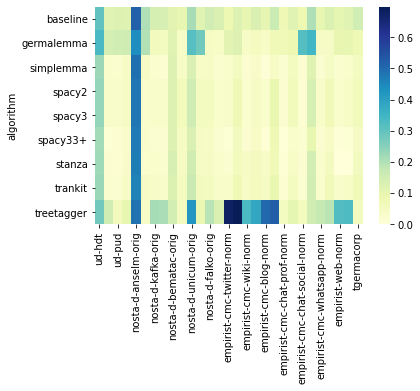

In [18]:
generate_table(data, ['metrics','overall','levenshtein-wordlen'])

In [14]:
# highest levenshtein diffs on ud-hdt, interesting!
# no huge difference between different levenshtein measures
# (for algos and corpora, but maybe diff with POS?)

In [ ]:
# comparison levenshtein & accuracy

In [98]:
# comparison by pos tag
def analysis_by_pos(dataset, metric='accuracy', split_uxpos=True):
    pos = pd.DataFrame(dtype='float')
    for item in data:
        lem = item["lemmatizer"]
        if (item['dataset'] == dataset) and (item["lemmatizer"] in algos) and \
        (item["lemmatizer"] not in pos.columns) and ('metrics' in item):
            tmp = pd.DataFrame.from_dict(item['metrics']).T
            tmp[lem] = tmp[metric]
            pos = pd.merge(pos, tmp[lem], left_index=True, right_index=True, how='right')
    dfs = [pos]
    if split_uxpos:
        # UPOS and XPOS tags
        upos, xpos = pos.iloc[1:6,:], pos.iloc[6:,:]
        dfs += [upos, xpos]
    return dfs

In [96]:
pos, upos, xpos = analysis_by_pos("nosta-d-tuebadz-orig")

In [97]:
upos

,baseline,germalemma,simplemma,spacy2,spacy3,spacy33+,stanza,trankit,treetagger
NOUN,0.72311,0.908413,0.907348,0.853035,0.853035,0.900958,0.895634,0.877529,0.884984
PROPN,0.948052,0.0,0.954545,0.957792,0.957792,0.980519,0.941558,0.935065,0.883117
VERB,0.296524,0.916155,0.770961,0.852761,0.852761,0.91002,0.889571,0.848671,0.848671
ADV,0.854237,0.969492,0.976271,0.833898,0.833898,0.969492,0.969492,0.959322,0.898305
ADJ,0.313131,0.838384,0.835859,0.729798,0.729798,0.876263,0.906566,0.835859,0.828283


In [80]:
xpos

,baseline,germalemma,simplemma,spacy2,spacy3,spacy33+,stanza,trankit,treetagger
ADJD,0.808696,0.930435,0.930435,0.808696,0.808696,0.93913,0.93913,0.895652,0.834783
NN,0.72311,0.908413,0.907348,0.853035,0.853035,0.900958,0.895634,0.877529,0.884984
NE,0.948052,0.0,0.954545,0.957792,0.957792,0.980519,0.941558,0.935065,0.883117
ADJA,0.11032,0.800712,0.797153,0.697509,0.697509,0.850534,0.893238,0.811388,0.825623
PAV,0.714286,0.892857,0.928571,0.785714,0.785714,0.928571,0.928571,0.928571,0.928571
VMINF,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
VVFIN,0.188525,0.893443,0.795082,0.827869,0.827869,0.868852,0.856557,0.811475,0.819672
VVIZU,0.0,0.714286,1.0,1.0,1.0,1.0,1.0,0.857143,1.0
VMPP,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
PWAV,0.666667,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [99]:
def pos_figure(pos=pos):
    figure(figsize=(10, 10), dpi=144)
    plt.imshow(pos.to_numpy(dtype='float'))
    plt.xticks(range(len(pos.columns)), list(pos.columns), rotation=90)
    plt.yticks(range(len(pos.index)), pos.index, rotation=0)
    plt.colorbar();
    plt.show();

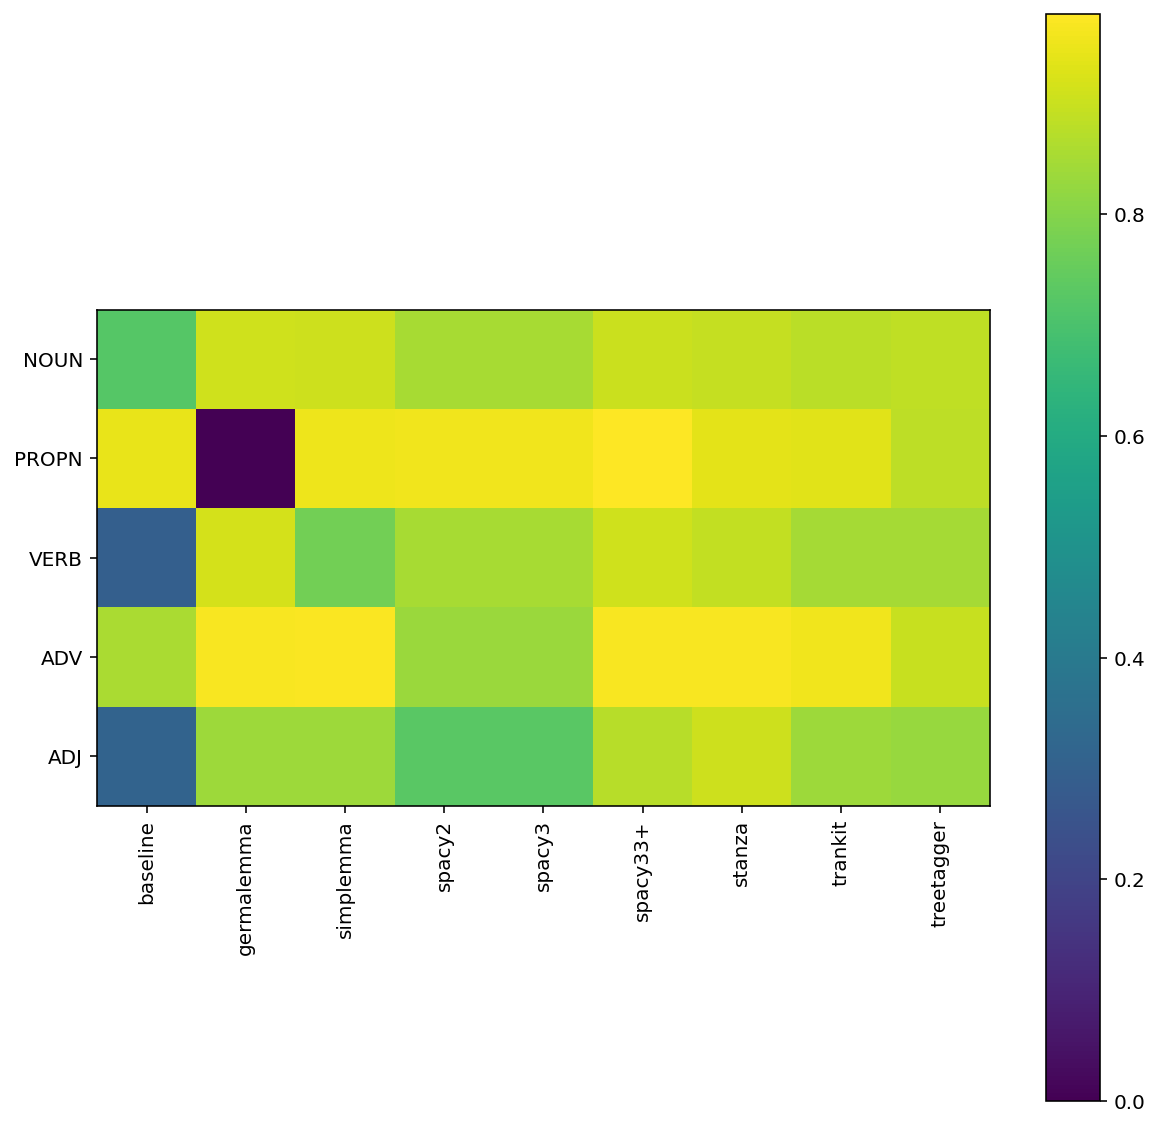

In [100]:
pos_figure(upos)

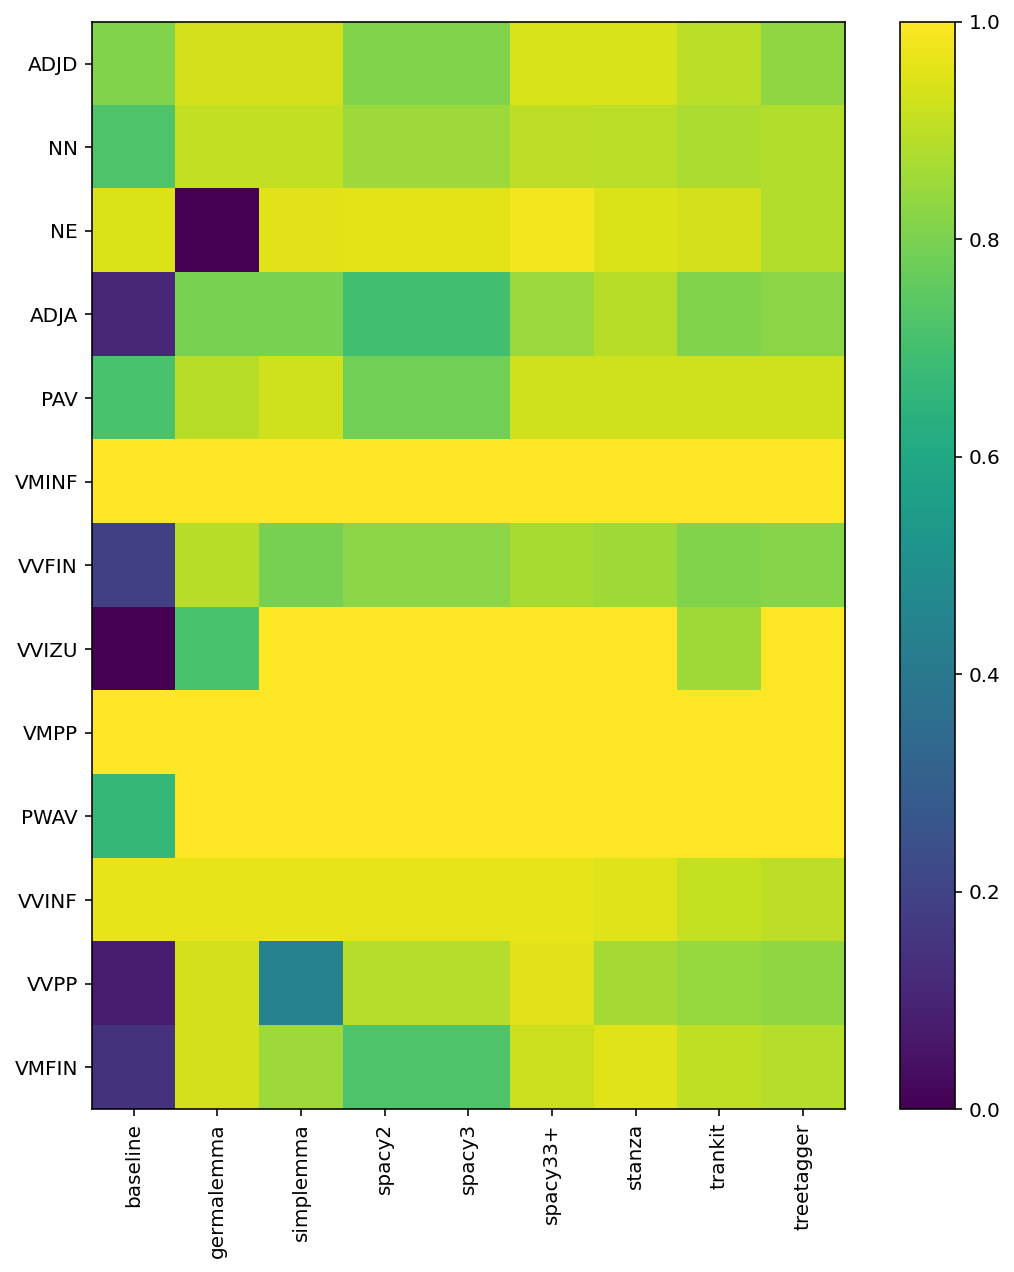

In [101]:
pos_figure(xpos)

Observations:
* baseline (unsurprisingly) performs best with least inflected word categories: adverbs and proper nouns
* germalemma performs worst on proper nouns
* simplemma (unlike other algos) performs better with adjectives, worse with verbs
* spacys(2,3,3.3): improved for almost all categories, but not proper nouns, interesting! 
* similar pattern for stanza & trankit: very good on all categories, worst on nouns and adjectives
* trankit and treetagger seem to struggle with finite verbs, infinitives (VVFIN, VVINF)

In [102]:
pos, upos, xpos = analysis_by_pos("nosta-d-tuebadz-orig", "levenshtein-wordlen")

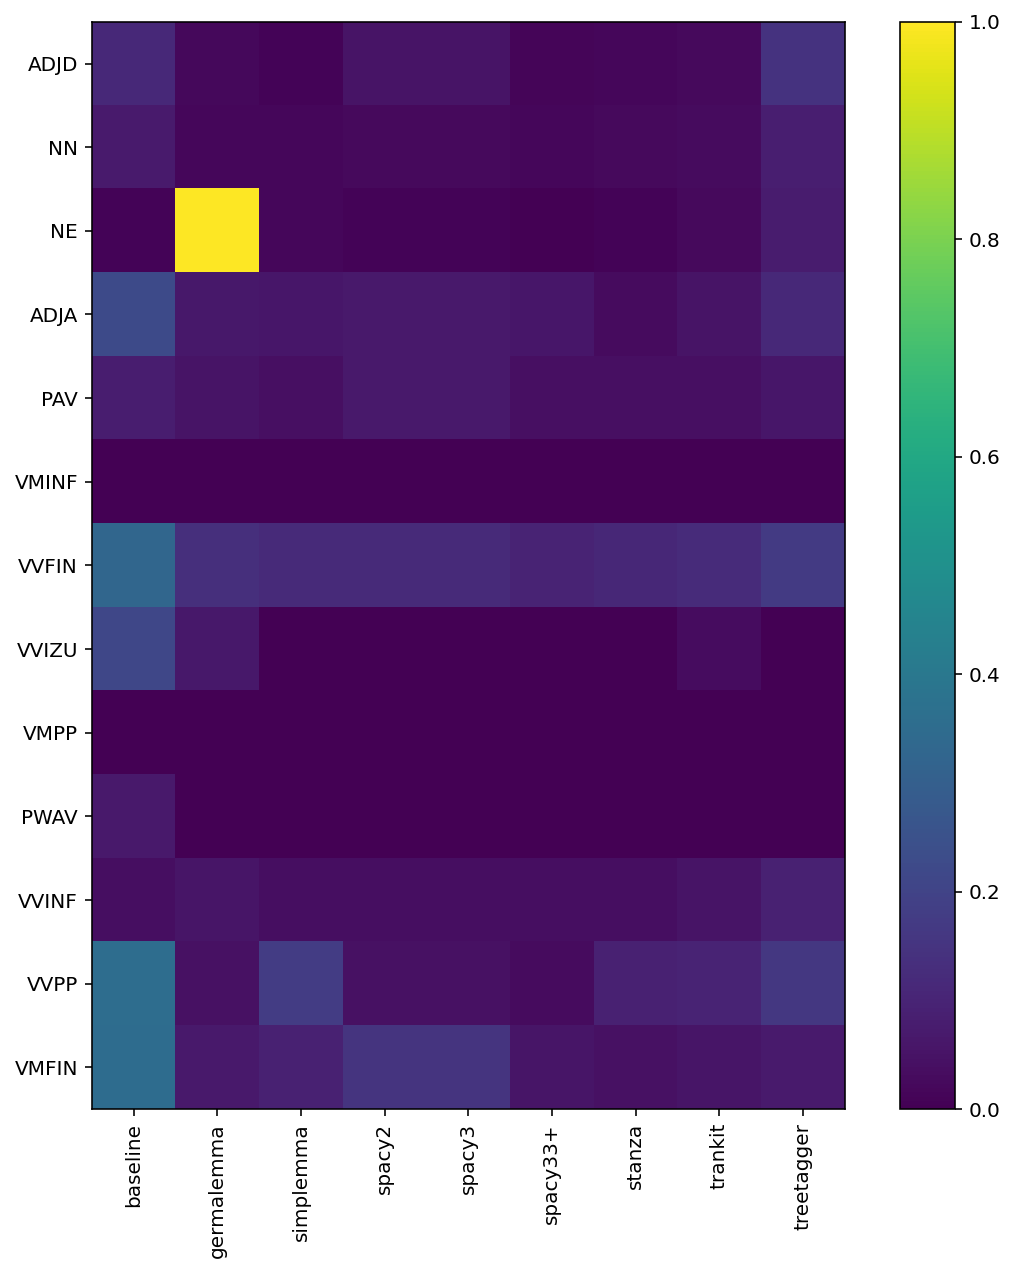

In [105]:
pos_figure(xpos)

,ud-hdt,ud-gsd,ud-pud,nosta-d-tuebadz-orig,nosta-d-anselm-orig,nosta-d-anselm-norm,nosta-d-kafka-orig,nosta-d-kafka-norm,nosta-d-bematac-orig,nosta-d-bematac-norm,...,empirist-cmc-blog,empirist-cmc-chat-prof-norm,empirist-cmc-chat-prof,empirist-cmc-chat-social-norm,empirist-cmc-chat-social,empirist-cmc-whatsapp-norm,empirist-cmc-whatsapp,empirist-web-norm,empirist-web,tgermacorp
algorithm,,,,,,,,,,,,,,,,,,,,,
baseline,0.442918,0.839068,0.815324,0.875874,0.713781,0.771863,0.792098,0.790610,1.059925,0.847619,...,0.915254,0.904290,0.856250,0.960159,0.845614,0.912409,0.874126,0.867008,0.852294,0.690186
germalemma,0.654886,1.189198,1.173421,1.100293,0.914027,1.097297,1.010804,1.005974,1.301149,1.160149,...,1.009346,1.057915,1.041825,1.158654,1.131455,1.016260,1.016260,1.083067,1.081340,0.999510
simplemma,0.556652,0.982407,0.977429,0.984928,0.745387,0.966667,0.996450,1.003576,1.325527,1.136861,...,0.964286,0.982079,0.944828,0.995868,0.902622,0.992063,0.968992,0.987618,0.979769,0.975779
spacy2,0.524243,0.964214,0.959722,0.967181,0.737226,0.953052,0.961187,0.951412,1.269058,1.019640,...,0.955752,0.975089,0.913333,0.995868,0.876364,0.976562,0.919118,0.972043,0.955603,0.909628
spacy3,0.524243,0.964214,0.959722,0.967181,0.737226,0.953052,0.961187,0.951412,1.269058,1.019640,...,0.955752,0.975089,0.913333,0.995868,0.876364,0.976562,0.919118,0.972043,0.955603,0.909628
spacy33+,0.569492,0.995093,0.992032,0.990771,0.708772,0.953052,1.004773,0.991755,1.219828,1.054146,...,0.955752,1.000000,0.964789,0.983673,0.873188,0.976562,0.946970,0.988338,0.981187,0.925468
stanza,0.547242,0.990488,0.987312,0.989467,0.731884,0.975962,0.991755,0.989424,1.269058,1.092982,...,0.955752,1.000000,0.944828,1.004167,0.886029,1.000000,0.961538,0.000000,0.000000,0.936678
trankit,0.534138,0.982157,0.981087,0.982353,0.768061,0.939815,0.980210,0.979070,1.225108,1.047059,...,0.947368,0.989170,0.928814,0.991770,0.879562,0.992063,0.946970,0.984749,0.978355,0.894910
treetagger,0.588631,1.061433,1.003830,0.997346,0.737226,0.966667,1.072611,1.071247,1.313225,1.141026,...,1.080000,0.989170,0.958042,1.012605,0.895911,0.954198,0.939850,1.090032,1.085669,0.979175


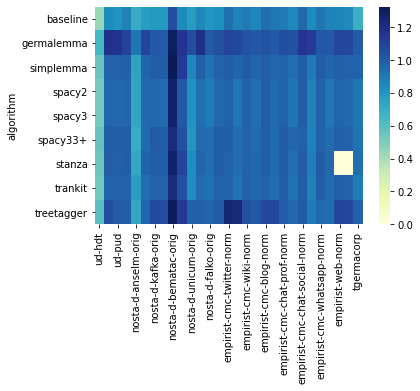

In [91]:
generate_table(data, ['metrics','overall','true-pred-types', 2])
# number of lemma types ratio: true / predicted
# > 1: less predicted than true lemmata
# -> some actual lemmata not captured by algorithm, generalized to different lemma
# < 1: more predicted than true lemmata
# -> algorithm more fine grained than gold data in corpus, or more cases where prediction=input

In [ ]:
# number of lemma types and tokens in gold data
df = pd.DataFrame(columns=upos.index+['overall'])
for d in data[:29]:  # baseline files
    for c in df.columns:  # upos tags
        

In [53]:
# check emissions
emissions = pd.DataFrame()
FILES = glob.glob("emissions/emissions-*.csv")
for FILE in FILES:
    algo = FILE.split("-")[1].replace('.csv', '')
    df = pd.read_csv(FILE)
    df['algorithm'] = algo
    emissions = pd.concat([emissions,df], axis=0)
emissions

,timestamp,project_name,run_id,duration,emissions,emissions_rate,cpu_power,gpu_power,ram_power,cpu_energy,...,cpu_count,cpu_model,gpu_count,gpu_model,longitude,latitude,ram_total_size,tracking_mode,on_cloud,algorithm
0,2023-01-27T14:18:19,codecarbon,87e18c6c-dc59-4838-8184-e9693fe75934,0.031973,5.873956e-08,0.001837,42.5,0.0,1.435059,1.887739e-07,...,4,Intel(R) Pentium(R) Silver N5000 CPU @ 1.10GHz,NaN,NaN,12.1224,49.1168,3.826824,machine,N,baseline
1,2023-01-27T14:34:56,codecarbon,16b26693-5421-4eae-bcc3-e75a362d8761,0.006547,2.326449e-08,0.003553,42.5,0.0,1.435059,7.729067e-08,...,4,Intel(R) Pentium(R) Silver N5000 CPU @ 1.10GHz,NaN,NaN,12.1224,49.1168,3.826824,machine,N,baseline
2,2023-01-27T14:35:20,codecarbon,6cf34cc0-810d-456b-b9d2-290500775222,0.015555,0.000000e+00,0.000000,42.5,0.0,1.435059,0.000000e+00,...,4,Intel(R) Pentium(R) Silver N5000 CPU @ 1.10GHz,NaN,NaN,12.1224,49.1168,3.826824,machine,N,baseline
0,2023-01-27T14:36:02,codecarbon,1b8b8d5d-572b-464c-9ec7-cf058245834a,0.068980,2.526123e-07,0.003662,42.5,0.0,1.435059,8.143413e-07,...,4,Intel(R) Pentium(R) Silver N5000 CPU @ 1.10GHz,NaN,NaN,12.1224,49.1168,3.826824,machine,N,simplemma
1,2023-01-27T14:36:22,codecarbon,1556b8ee-e995-4f97-bbe9-4dd5a427e833,0.053401,1.387475e-07,0.002598,42.5,0.0,1.435059,4.458990e-07,...,4,Intel(R) Pentium(R) Silver N5000 CPU @ 1.10GHz,NaN,NaN,12.1224,49.1168,3.826824,machine,N,simplemma
2,2023-01-27T15:08:40,codecarbon,b8e73107-9725-48c1-a78f-953215513fa6,0.331974,1.219491e-06,0.003673,42.5,0.0,1.435059,3.919132e-06,...,4,Intel(R) Pentium(R) Silver N5000 CPU @ 1.10GHz,NaN,NaN,12.1224,49.1168,3.826824,machine,N,simplemma
3,2023-01-27T15:09:03,codecarbon,faad95cc-3732-408f-b2ee-434644d2b1a5,0.046874,1.721908e-07,0.003673,42.5,0.0,1.435059,5.533770e-07,...,4,Intel(R) Pentium(R) Silver N5000 CPU @ 1.10GHz,NaN,NaN,12.1224,49.1168,3.826824,machine,N,simplemma
4,2023-01-27T15:18:41,codecarbon,c2039ccf-ca91-4fb6-bc66-379b4f4b3b39,0.022192,8.152316e-08,0.003673,42.5,0.0,1.435059,2.619945e-07,...,4,Intel(R) Pentium(R) Silver N5000 CPU @ 1.10GHz,NaN,NaN,12.1224,49.1168,3.826824,machine,N,simplemma
5,2023-01-27T15:19:00,codecarbon,4f3e685c-3007-4f26-9755-51a53bb82b53,0.037824,1.389464e-07,0.003673,42.5,0.0,1.435059,4.465380e-07,...,4,Intel(R) Pentium(R) Silver N5000 CPU @ 1.10GHz,NaN,NaN,12.1224,49.1168,3.826824,machine,N,simplemma


In [58]:
# sum by algo
emissions_sum = emissions.groupby('algorithm').sum()
emissions_sum

,duration,emissions,emissions_rate,cpu_power,gpu_power,ram_power,cpu_energy,gpu_energy,ram_energy,energy_consumed,cloud_provider,cloud_region,cpu_count,gpu_count,gpu_model,longitude,latitude,ram_total_size
algorithm,,,,,,,,,,,,,,,,,,
baseline,0.054075,8.200405e-08,0.005391,127.5,0.0,4.305177,2.660645e-07,0,6.374157e-09,2.724387e-07,0.0,0.0,12,0.0,0.0,36.3672,147.3504,11.480473
simplemma,0.561245,2.003511e-06,0.020954,255.0,0.0,8.610354,6.441282e-06,0,2.149021e-07,6.656184e-06,0.0,0.0,24,0.0,0.0,72.7344,294.7008,22.960945
